In [1]:
import random
import torch
import numpy as np

def set_seed(seed=116):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  

set_seed(116)

# 1. Build your own convolutional neural network using pytorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import copy

class CNNBiLSTM(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNBiLSTM, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.3)

        self.lstm1 = nn.LSTM(input_size=512, hidden_size=512, num_layers=2, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=1024, hidden_size=512, num_layers=2, bidirectional=True, batch_first=True)

        self.fc1 = nn.Linear(1024, 64)
        self.fc_dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv3(self.relu(self.conv2(x))))))
        x = self.pool(self.relu(self.bn4(self.conv5(self.relu(self.conv4(x))))))
        x = self.pool(self.relu(self.bn5(self.conv6(x))))
        
        x = x.view(x.size(0), -1, 512)

        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        x = x[:, -1, :]

        x = self.fc_dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CNNBiLSTM(num_classes=3)
print(model)

CNNBiLSTM(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm1): LSTM(512, 512, num_layers=2, batch_first=True, bidirectional=True)
  (lstm2): LSTM(1024, 512, num_la

# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dir = "/kaggle/input/dog-cardiomegaly/Dog_X_ray/Dog_heart/Dog_heart/Train"
valid_dir = "/kaggle/input/dog-cardiomegaly/Dog_X_ray/Dog_heart/Dog_heart/Valid"

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(valid_dataset))

Number of training samples: 1400
Number of validation samples: 200


In [4]:

model = CNNBiLSTM(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

early_stopping_patience = 25
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

def train_model_with_early_stopping(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=50):
    global best_val_loss, patience_counter, best_model_state

    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_loss /= len(train_loader)
        
        model.eval()
        valid_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        valid_acc = 100 * correct / total
        valid_loss /= len(valid_loader)

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered!")
            break

        #scheduler.step()
        scheduler.step(valid_loss)

        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['train_acc'].append(train_acc)
        history['valid_acc'].append(valid_acc)
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Valid Loss={valid_loss:.4f}, Valid Acc={valid_acc:.2f}%")

    model.load_state_dict(best_model_state)
    return history

history = train_model_with_early_stopping(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=128)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/128: Train Loss=1.0435, Train Acc=42.21%, Valid Loss=1.1346, Valid Acc=38.00%


Epoch 2/128: Train Loss=1.0070, Train Acc=42.64%, Valid Loss=1.0963, Valid Acc=38.00%


Epoch 3/128: Train Loss=0.9846, Train Acc=42.71%, Valid Loss=1.0935, Valid Acc=39.00%


Epoch 4/128: Train Loss=0.9699, Train Acc=45.43%, Valid Loss=0.9488, Valid Acc=58.50%


Epoch 5/128: Train Loss=0.9052, Train Acc=51.64%, Valid Loss=0.9722, Valid Acc=49.50%


Epoch 6/128: Train Loss=0.8831, Train Acc=49.57%, Valid Loss=0.9232, Valid Acc=53.50%


Epoch 7/128: Train Loss=0.8572, Train Acc=51.93%, Valid Loss=0.8341, Valid Acc=55.50%


Epoch 8/128: Train Loss=0.8456, Train Acc=50.93%, Valid Loss=0.8293, Valid Acc=54.00%


Epoch 9/128: Train Loss=0.8400, Train Acc=52.64%, Valid Loss=0.8521, Valid Acc=51.00%


Epoch 10/128: Train Loss=0.8024, Train Acc=55.07%, Valid Loss=1.0960, Valid Acc=42.50%


Epoch 11/128: Train Loss=0.8212, Train Acc=52.07%, Valid Loss=0.7370, Valid Acc=59.00%


Epoch 12/128: Train Loss=0.7849, Train Acc=56.57%, Valid Loss=0.8642, Valid Acc=52.00%


Epoch 13/128: Train Loss=0.7787, Train Acc=55.64%, Valid Loss=0.7168, Valid Acc=59.50%


Epoch 14/128: Train Loss=0.7822, Train Acc=56.64%, Valid Loss=0.8257, Valid Acc=58.50%


Epoch 15/128: Train Loss=0.7922, Train Acc=55.86%, Valid Loss=0.7400, Valid Acc=59.50%


Epoch 16/128: Train Loss=0.7709, Train Acc=57.50%, Valid Loss=0.9235, Valid Acc=50.00%


Epoch 17/128: Train Loss=0.7997, Train Acc=55.57%, Valid Loss=0.8284, Valid Acc=53.50%


Epoch 18/128: Train Loss=0.7442, Train Acc=59.07%, Valid Loss=0.7232, Valid Acc=61.00%


Epoch 19/128: Train Loss=0.7804, Train Acc=56.29%, Valid Loss=0.8520, Valid Acc=56.00%


Epoch 20/128: Train Loss=0.7726, Train Acc=57.50%, Valid Loss=0.7666, Valid Acc=53.50%


Epoch 21/128: Train Loss=0.7444, Train Acc=60.21%, Valid Loss=0.7726, Valid Acc=59.00%


Epoch 22/128: Train Loss=0.7492, Train Acc=57.71%, Valid Loss=0.7132, Valid Acc=66.00%


Epoch 23/128: Train Loss=0.7386, Train Acc=59.14%, Valid Loss=0.8772, Valid Acc=53.00%


Epoch 24/128: Train Loss=0.7518, Train Acc=58.43%, Valid Loss=0.6622, Valid Acc=65.00%


Epoch 25/128: Train Loss=0.7202, Train Acc=60.36%, Valid Loss=0.6800, Valid Acc=63.00%


Epoch 26/128: Train Loss=0.7410, Train Acc=58.50%, Valid Loss=0.9491, Valid Acc=53.50%


Epoch 27/128: Train Loss=0.7203, Train Acc=60.93%, Valid Loss=0.8239, Valid Acc=58.50%


Epoch 28/128: Train Loss=0.7343, Train Acc=59.00%, Valid Loss=0.7332, Valid Acc=65.00%


Epoch 29/128: Train Loss=0.7202, Train Acc=61.14%, Valid Loss=0.7899, Valid Acc=57.00%


Epoch 30/128: Train Loss=0.7239, Train Acc=60.29%, Valid Loss=0.6892, Valid Acc=68.50%


Epoch 31/128: Train Loss=0.6936, Train Acc=63.00%, Valid Loss=0.6367, Valid Acc=67.00%


Epoch 32/128: Train Loss=0.6901, Train Acc=64.93%, Valid Loss=0.6140, Valid Acc=64.00%


Epoch 33/128: Train Loss=0.7078, Train Acc=64.07%, Valid Loss=0.6187, Valid Acc=66.50%


Epoch 34/128: Train Loss=0.6810, Train Acc=63.86%, Valid Loss=0.7562, Valid Acc=66.00%


Epoch 35/128: Train Loss=0.7099, Train Acc=63.79%, Valid Loss=0.6369, Valid Acc=67.50%


Epoch 36/128: Train Loss=0.6891, Train Acc=64.43%, Valid Loss=0.6796, Valid Acc=65.50%


Epoch 37/128: Train Loss=0.6850, Train Acc=64.29%, Valid Loss=0.6687, Valid Acc=64.00%


Epoch 38/128: Train Loss=0.6994, Train Acc=64.64%, Valid Loss=0.6743, Valid Acc=66.50%


Epoch 39/128: Train Loss=0.6798, Train Acc=67.93%, Valid Loss=0.6417, Valid Acc=68.00%


Epoch 40/128: Train Loss=0.7038, Train Acc=64.57%, Valid Loss=0.6611, Valid Acc=64.00%


Epoch 41/128: Train Loss=0.6863, Train Acc=65.64%, Valid Loss=0.8314, Valid Acc=52.00%


Epoch 45/128: Train Loss=0.6386, Train Acc=69.43%, Valid Loss=0.5973, Valid Acc=69.00%


Epoch 46/128: Train Loss=0.6377, Train Acc=69.57%, Valid Loss=0.6082, Valid Acc=71.50%


Epoch 47/128: Train Loss=0.6436, Train Acc=68.29%, Valid Loss=0.6204, Valid Acc=66.50%


Epoch 48/128: Train Loss=0.6390, Train Acc=68.50%, Valid Loss=0.6311, Valid Acc=68.00%


Epoch 49/128: Train Loss=0.6192, Train Acc=70.79%, Valid Loss=0.6378, Valid Acc=64.50%


Epoch 50/128: Train Loss=0.6161, Train Acc=71.07%, Valid Loss=0.6332, Valid Acc=68.00%


Epoch 51/128: Train Loss=0.6177, Train Acc=71.71%, Valid Loss=0.6317, Valid Acc=69.50%


Epoch 52/128: Train Loss=0.6074, Train Acc=71.43%, Valid Loss=0.5613, Valid Acc=69.00%


Epoch 53/128: Train Loss=0.6017, Train Acc=70.93%, Valid Loss=0.6378, Valid Acc=67.00%


Epoch 54/128: Train Loss=0.6006, Train Acc=72.00%, Valid Loss=0.6196, Valid Acc=72.00%


Epoch 55/128: Train Loss=0.5833, Train Acc=73.36%, Valid Loss=0.5927, Valid Acc=68.50%


Epoch 56/128: Train Loss=0.5906, Train Acc=71.50%, Valid Loss=0.6540, Valid Acc=67.50%


Epoch 57/128: Train Loss=0.5727, Train Acc=72.57%, Valid Loss=0.5867, Valid Acc=69.50%


Epoch 58/128: Train Loss=0.5762, Train Acc=73.50%, Valid Loss=0.5972, Valid Acc=73.00%


Epoch 59/128: Train Loss=0.5887, Train Acc=73.36%, Valid Loss=0.5950, Valid Acc=68.50%


Epoch 60/128: Train Loss=0.5784, Train Acc=72.29%, Valid Loss=0.6887, Valid Acc=69.00%


Epoch 61/128: Train Loss=0.5954, Train Acc=72.93%, Valid Loss=0.6073, Valid Acc=70.00%


Epoch 62/128: Train Loss=0.5748, Train Acc=72.57%, Valid Loss=0.6014, Valid Acc=67.50%


Epoch 63/128: Train Loss=0.5792, Train Acc=73.14%, Valid Loss=0.6053, Valid Acc=69.00%


Epoch 64/128: Train Loss=0.5720, Train Acc=74.21%, Valid Loss=0.5640, Valid Acc=69.50%


Epoch 65/128: Train Loss=0.5710, Train Acc=72.14%, Valid Loss=0.5766, Valid Acc=72.00%


Epoch 66/128: Train Loss=0.5420, Train Acc=75.79%, Valid Loss=0.5690, Valid Acc=74.00%


Epoch 67/128: Train Loss=0.5389, Train Acc=76.07%, Valid Loss=0.5768, Valid Acc=73.00%


Epoch 68/128: Train Loss=0.5465, Train Acc=75.57%, Valid Loss=0.7862, Valid Acc=65.00%


Epoch 69/128: Train Loss=0.5495, Train Acc=74.79%, Valid Loss=0.5895, Valid Acc=70.00%


Epoch 70/128: Train Loss=0.5366, Train Acc=76.50%, Valid Loss=0.6452, Valid Acc=69.00%


Epoch 71/128: Train Loss=0.5462, Train Acc=76.00%, Valid Loss=0.5879, Valid Acc=68.50%


Epoch 72/128: Train Loss=0.5199, Train Acc=76.86%, Valid Loss=0.5842, Valid Acc=68.00%


Epoch 73/128: Train Loss=0.5272, Train Acc=76.00%, Valid Loss=0.5636, Valid Acc=71.50%


Epoch 74/128: Train Loss=0.5247, Train Acc=75.21%, Valid Loss=0.5553, Valid Acc=73.00%


Epoch 75/128: Train Loss=0.5263, Train Acc=76.00%, Valid Loss=0.6218, Valid Acc=70.50%


Epoch 76/128: Train Loss=0.5027, Train Acc=77.07%, Valid Loss=0.6243, Valid Acc=69.00%


Epoch 77/128: Train Loss=0.5153, Train Acc=77.93%, Valid Loss=0.6475, Valid Acc=72.50%


Epoch 78/128: Train Loss=0.5122, Train Acc=77.79%, Valid Loss=0.6706, Valid Acc=72.00%


Epoch 79/128: Train Loss=0.4923, Train Acc=78.79%, Valid Loss=0.5572, Valid Acc=73.00%


Epoch 80/128: Train Loss=0.5103, Train Acc=78.07%, Valid Loss=0.5702, Valid Acc=74.00%


Epoch 81/128: Train Loss=0.5196, Train Acc=76.79%, Valid Loss=0.5619, Valid Acc=75.50%


Epoch 82/128: Train Loss=0.5094, Train Acc=76.64%, Valid Loss=0.5806, Valid Acc=71.00%


Epoch 83/128: Train Loss=0.5137, Train Acc=77.64%, Valid Loss=0.5652, Valid Acc=72.50%


Epoch 84/128: Train Loss=0.4850, Train Acc=78.50%, Valid Loss=0.5597, Valid Acc=76.00%


Epoch 85/128: Train Loss=0.4896, Train Acc=78.57%, Valid Loss=0.5857, Valid Acc=75.00%


Epoch 86/128: Train Loss=0.4918, Train Acc=79.64%, Valid Loss=0.5768, Valid Acc=73.50%


Epoch 87/128: Train Loss=0.4825, Train Acc=80.57%, Valid Loss=0.5576, Valid Acc=73.50%


Epoch 88/128: Train Loss=0.4594, Train Acc=81.21%, Valid Loss=0.5507, Valid Acc=74.50%


Epoch 89/128: Train Loss=0.4773, Train Acc=80.43%, Valid Loss=0.5763, Valid Acc=71.50%


Epoch 90/128: Train Loss=0.4773, Train Acc=79.21%, Valid Loss=0.5465, Valid Acc=75.50%


Epoch 91/128: Train Loss=0.4557, Train Acc=81.21%, Valid Loss=0.5660, Valid Acc=75.00%


Epoch 92/128: Train Loss=0.4661, Train Acc=80.36%, Valid Loss=0.5645, Valid Acc=74.00%


Epoch 93/128: Train Loss=0.4547, Train Acc=81.21%, Valid Loss=0.5454, Valid Acc=74.00%


Epoch 94/128: Train Loss=0.4535, Train Acc=81.57%, Valid Loss=0.5949, Valid Acc=71.00%


Epoch 95/128: Train Loss=0.4691, Train Acc=80.00%, Valid Loss=0.5492, Valid Acc=74.00%


Epoch 96/128: Train Loss=0.4322, Train Acc=82.64%, Valid Loss=0.5688, Valid Acc=75.50%


Epoch 97/128: Train Loss=0.4529, Train Acc=80.57%, Valid Loss=0.5546, Valid Acc=73.00%


Epoch 98/128: Train Loss=0.4611, Train Acc=82.14%, Valid Loss=0.5782, Valid Acc=75.50%


Epoch 99/128: Train Loss=0.4384, Train Acc=82.21%, Valid Loss=0.6127, Valid Acc=72.50%


Epoch 100/128: Train Loss=0.4296, Train Acc=82.93%, Valid Loss=0.5518, Valid Acc=76.00%


Epoch 101/128: Train Loss=0.4423, Train Acc=81.79%, Valid Loss=0.5540, Valid Acc=76.00%


Epoch 102/128: Train Loss=0.4508, Train Acc=80.36%, Valid Loss=0.6117, Valid Acc=76.00%


Epoch 103/128: Train Loss=0.4424, Train Acc=82.21%, Valid Loss=0.5889, Valid Acc=74.50%


Epoch 104/128: Train Loss=0.4497, Train Acc=80.50%, Valid Loss=0.6210, Valid Acc=72.00%


Epoch 105/128: Train Loss=0.4136, Train Acc=83.64%, Valid Loss=0.5695, Valid Acc=76.00%


Epoch 106/128: Train Loss=0.4239, Train Acc=82.00%, Valid Loss=0.5757, Valid Acc=75.00%


Epoch 107/128: Train Loss=0.4265, Train Acc=82.29%, Valid Loss=0.5590, Valid Acc=74.00%


Epoch 108/128: Train Loss=0.4533, Train Acc=80.79%, Valid Loss=0.5457, Valid Acc=76.50%


Epoch 109/128: Train Loss=0.4271, Train Acc=83.43%, Valid Loss=0.5656, Valid Acc=74.50%


Epoch 110/128: Train Loss=0.4170, Train Acc=83.14%, Valid Loss=0.5542, Valid Acc=76.00%


Epoch 111/128: Train Loss=0.4463, Train Acc=81.29%, Valid Loss=0.5565, Valid Acc=75.00%


Epoch 112/128: Train Loss=0.4348, Train Acc=81.86%, Valid Loss=0.5502, Valid Acc=76.50%


Epoch 113/128: Train Loss=0.4357, Train Acc=82.50%, Valid Loss=0.5518, Valid Acc=75.50%


Epoch 114/128: Train Loss=0.4192, Train Acc=81.79%, Valid Loss=0.5559, Valid Acc=74.00%


Epoch 115/128: Train Loss=0.4251, Train Acc=83.43%, Valid Loss=0.5483, Valid Acc=75.00%


Epoch 116/128: Train Loss=0.4241, Train Acc=82.71%, Valid Loss=0.5441, Valid Acc=76.00%


Epoch 117/128: Train Loss=0.4184, Train Acc=81.64%, Valid Loss=0.5432, Valid Acc=76.00%


Epoch 118/128: Train Loss=0.4159, Train Acc=83.93%, Valid Loss=0.5438, Valid Acc=76.50%


Epoch 119/128: Train Loss=0.3964, Train Acc=84.14%, Valid Loss=0.5503, Valid Acc=76.00%


Epoch 120/128: Train Loss=0.4087, Train Acc=83.79%, Valid Loss=0.5595, Valid Acc=75.00%


Epoch 121/128: Train Loss=0.3818, Train Acc=84.93%, Valid Loss=0.5690, Valid Acc=76.00%


Epoch 122/128: Train Loss=0.3950, Train Acc=84.71%, Valid Loss=0.5558, Valid Acc=77.50%


Epoch 123/128: Train Loss=0.4084, Train Acc=84.07%, Valid Loss=0.5547, Valid Acc=77.50%


Epoch 124/128: Train Loss=0.4086, Train Acc=84.07%, Valid Loss=0.5498, Valid Acc=76.50%


Epoch 125/128: Train Loss=0.4123, Train Acc=84.07%, Valid Loss=0.5435, Valid Acc=77.00%


Epoch 126/128: Train Loss=0.4068, Train Acc=83.93%, Valid Loss=0.5403, Valid Acc=77.00%


Epoch 127/128: Train Loss=0.4148, Train Acc=83.57%, Valid Loss=0.5450, Valid Acc=76.00%


Epoch 128/128: Train Loss=0.3990, Train Acc=83.57%, Valid Loss=0.5514, Valid Acc=75.00%


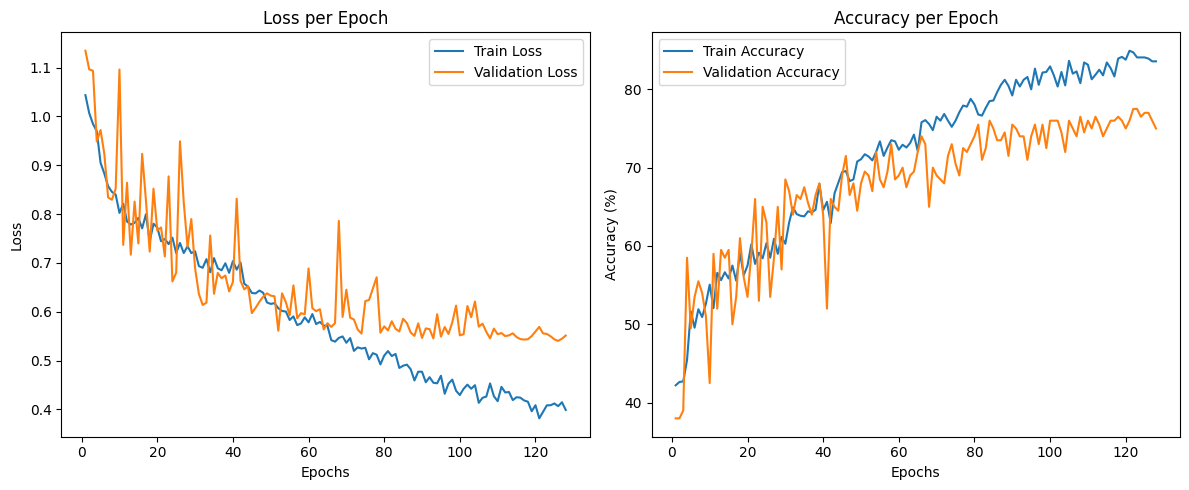

In [5]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['valid_loss'], label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['valid_acc'], label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

Evaluating: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.76      0.72      0.74        76
     Class 1       0.75      0.74      0.74        91
     Class 2       0.82      0.97      0.89        33

    accuracy                           0.77       200
   macro avg       0.78      0.81      0.79       200
weighted avg       0.77      0.77      0.77       200



<Figure size 800x800 with 0 Axes>

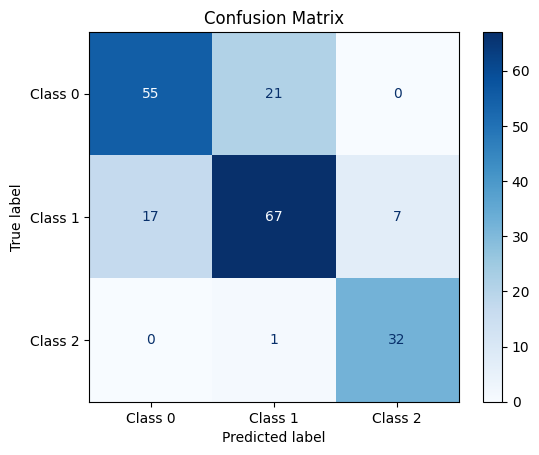

In [6]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = model.to(device)

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1", "Class 2"]))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
    plt.figure(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, valid_loader)

Evaluating: 100%|██████████| 44/44 [00:40<00:00,  1.10it/s]


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.85      0.89      0.87       619
     Class 1       0.85      0.79      0.82       573
     Class 2       0.91      0.94      0.93       208

    accuracy                           0.86      1400
   macro avg       0.87      0.88      0.87      1400
weighted avg       0.86      0.86      0.86      1400



<Figure size 800x800 with 0 Axes>

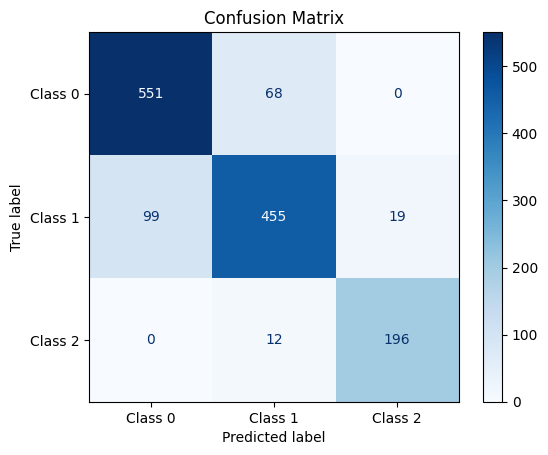

In [7]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


model = model.to(device)

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1", "Class 2"]))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
    plt.figure(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
›

In [9]:

def save_model(model, path="model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

save_model(model, "trained_model_p2.pth")


Model saved to trained_model_p2.pth


In [3]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomTestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_filenames = [img for img in os.listdir(image_dir) if img.endswith('.png')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name

test_dir = "/kaggle/input/dog-cardiomegaly/Dog_X_ray/Test/Test"

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = CustomTestDataset(image_dir=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNBiLSTM(num_classes=3).to(device)
model.load_state_dict(torch.load("/kaggle/input/cnn_bilstm/pytorch/default/1/trained_model_p2.pth"))
model.eval()

results = []

with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        labels = predicted.cpu().numpy()

        for filename, label in zip(filenames, labels):
            results.append([filename, label])

df = pd.DataFrame(results, columns=["Image", "Label"])
df.to_csv("p2.csv", sep='\t', index=False, header=False)
print("Predictions saved.")

/tmp/ipykernel_30/1840502830.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/cnn_bilstm/pytorch/default/1/trained_model_

Predictions saved.


https://www.researchgate.net/publication/385944098_Deep_Feature_Extraction_Using_BiLSTM_for_Canine_Cardiomegaly_Detection